# 1.この課題の目的
フレームワークのコードを読めるようにする
フレームワークを習得し続けられるようになる
理論を知っている範囲をフレームワークで動かす
以下の要件をすべて満たしていた場合、合格とします。

※Jupyter Notebookを使い課題に沿った検証や説明ができている。

2.公式Example
深層学習フレームワークには公式に様々なモデルのExampleコードが公開されています。

# 【問題1】公式Exampleを分担して実行
TensorFLowの公式Exampleを分担して実行してください。

以下の中から1人ひとつ選び実行し、その結果を簡単に発表してください。

## research

定番のモデルから最新のモデルまで多様なコードが公開されています。

[models/research at master · tensorflow/models](https://github.com/tensorflow/models/tree/master/research)

## tutorials

TensorFLowのチュートリアルとして用意された簡単なモデルが含まれています。

[models/tutorials at master · tensorflow/models](https://github.com/tensorflow/models/tree/master/tutorials)

### →確認した内容　tutorials：[Custom training: basics](https://www.tensorflow.org/tutorials/eager/custom_training)
### 以下に詳細を記載

## 「Custom training: basics」
前のチュートリアルでは、自動で学習する為のTensorFlow API、機械学習の基本的な構成要素について説明しました。このチュートリアルでは、前のチュートリアルで紹介したTensorFlowの基本機能を使って簡単な機械学習を行います。

TensorFlowには、定型文を削減するための有用な抽象化を提供する高レベルのニューラルネットワークAPI（tf.keras）があります。ニューラルネットワークを扱う人々には、これらの高レベルAPIの使用を強くお勧めします。ただし、この短いチュートリアルでは、しっかりとした基礎を確立するために、このKerasを使用せずにTensorFlowの最初の原則から説明します。

### セットアップ

In [1]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe

tfe.enable_eager_execution()

### 変数

TensorFlowのテンソルは、イミュータブルなステートレスオブジェクトです。しかし、機械学習モデルは変化する状態を持つ必要があります。モデルのトレーニング時に、予測を計算するためのコードは、時間の経過とともに値を更新し続ける動作をする必要があります（損失を少なくするように値を更新する）。その計算の過程で変数を変化させる必要がありますが、この状態を表現する為に、Pythonがステートフル言語であるのでこの問題を解消しています。

補足
- ステートフル　→　一度、設定した情報が保持されるので、次回、設定した情報を使用する時は再度の設定は不要
- ステートレス　→　使用するたびに設定する必要がある

In [2]:
# Pythonを使用した場合
x = tf.zeros([10, 10])
x += 2  # これはx = x + 2と等価であり、xの元の値は変わりません。
print(x)

tf.Tensor(
[[2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]], shape=(10, 10), dtype=float32)


TensorFlowには、ステートフルな操作が組み込まれています。これらの操作は、Pythonによる表現より効率的です。例としてはモデル内で重みを表す際などはTensorFlow変数を使用すると便利です。

変数は値を格納するオブジェクトであり、TensorFlow計算で使用されると、この格納された変数から値が読み取られます。この際はtf.assign_sub、tf.scatter_updateなどを行います。

In [3]:
# 変数を定義
v = tf.Variable(1.0)
assert v.numpy() == 1.0

# 値を代入
v.assign(3.0)
assert v.numpy() == 3.0

# 自乗計算
v.assign(tf.square(v))
assert v.numpy() == 9.0

変数を使用し勾配を計算するときに自動的にトレース(順番に計算)されます。埋め込みを表す変数の場合、TensorFlowはデフォルトでスパース更新を実行します。これは、計算とメモリの効率を高める為です。

変数を使用する事は、プログラムを読む人に状態が変更可能であることを知らせる事にもなります。

### 例：線形モデルを実装する
まずは今までに紹介したいくつかの概念を設定しましょう。Tensor、GradientTape、Variable。
これには通常、以下の手順で行われます。

1. モデルの定義
2. 損失関数の定義
3. 訓練データの設定
4. 「オプティマイザ」を使用してデータに合わせて変数を調整

このチュートリアルでは、単純な線形モデルの簡単な例で考えましょう。
$$f(x)=XW+b$$
この関数は2つの変数を$W$と$b$を持ちます。初期値として$W=3.0$と$b=2.0$とします。

### モデルを定義する
変数と計算をカプセル化する簡単なクラスを定義しましょう。

In [4]:
# モデル定義
class Model(object):
    
    #重みとバイアスの初期設定
    def __init__(self):
        # Initialize variable to (5.0, 0.0)
        # In practice, these should be initialized to random values.
        self.W = tf.Variable(5.0)
        self.b = tf.Variable(0.0)
    
    def __call__(self, x):
        return self.W * x + self.b

# インスタンス作成
model = Model()

# 実行
assert model(3.0).numpy() == 15.0

Instructions for updating:
Colocations handled automatically by placer.


### 損失関数を定義する
損失関数は、特定の入力に対するモデルの出力が目的の出力にどれだけ一致するかを測定します。標準のL2損失を使用しましょう。

In [5]:
def loss(predicted_y, desired_y):
    return tf.reduce_mean(tf.square(predicted_y - desired_y))

### トレーニングデータを入手する
いくつかのノイズを含むトレーニングデータを合成しましょう。

In [6]:
# 予測をする重みとバイアスの設定→この値に近くよう学習させる
TRUE_W = 3.0
TRUE_b = 2.0
NUM_EXAMPLES = 1000

# 入力データの作成
inputs  = tf.random_normal(shape=[NUM_EXAMPLES])

# ノイズデータの作成
noise   = tf.random_normal(shape=[NUM_EXAMPLES])

# トレーニングデータの作成
outputs = inputs * TRUE_W + TRUE_b + noise

モデルをトレーニングする前に、モデルが現在どこにあるかを視覚化しましょう。モデルの予測を赤で、トレーニングデータを青でプロットします。

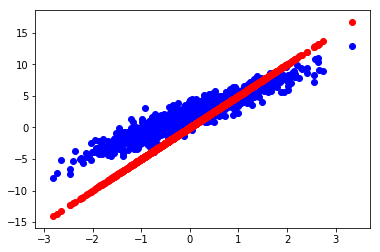

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

# トレーニングデータを散布図で表示
plt.scatter(inputs, outputs, c='b')

# 正解データの表示
plt.scatter(inputs, model(inputs), c='r')

plt.show()

In [8]:
# 現状のロスの表示
print('Current loss: '),
print(loss(model(inputs), outputs).numpy())

Current loss: 
8.719667


### トレーニングループを定義する
ネットワークとトレーニングデータがあります。それを訓練しましょう。すなわち、損失が勾配降下法を使用して減少するように、モデルの変数（Wおよびb）を更新するためにトレーニングデータを使用します。勾配降下法のアルゴリズムはTensorFlowのtf.train.Optimizerに実装されています。これらの実装を使用することを強くお勧めしますが、今回は最初の原則から構築しますので、自分で実装します。

In [9]:
# 学習モデルの作成
def train(model, inputs, outputs, learning_rate):
    with tf.GradientTape() as t:
        current_loss = loss(model(inputs), outputs)
        dW, db = t.gradient(current_loss, [model.W, model.b])
        model.W.assign_sub(learning_rate * dW)
        model.b.assign_sub(learning_rate * db)

最後に、トレーニングデータを繰り返し調べて、$W$と$b$がどのように変化するのかを確認します。

Epoch  0: W=5.00 b=0.00, loss=8.71967
Epoch  1: W=4.62 b=0.38, loss=6.05186
Epoch  2: W=4.30 b=0.69, loss=4.30410
Epoch  3: W=4.05 b=0.94, loss=3.15907
Epoch  4: W=3.85 b=1.15, loss=2.40890
Epoch  5: W=3.68 b=1.31, loss=1.91739
Epoch  6: W=3.54 b=1.44, loss=1.59537
Epoch  7: W=3.43 b=1.55, loss=1.38437
Epoch  8: W=3.35 b=1.63, loss=1.24612
Epoch  9: W=3.27 b=1.70, loss=1.15554


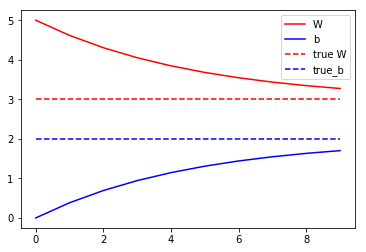

In [10]:
model = Model()

# 学習
Ws, bs = [], []
epochs = range(10)
for epoch in epochs:
    Ws.append(model.W.numpy())
    bs.append(model.b.numpy())
    current_loss = loss(model(inputs), outputs)
    
    train(model, inputs, outputs, learning_rate=0.1)
    print('Epoch %2d: W=%1.2f b=%1.2f, loss=%2.5f' %
          (epoch, Ws[-1], bs[-1], current_loss))

# 学習曲線の表示
plt.plot(epochs, Ws, 'r',
         epochs, bs, 'b')
plt.plot([TRUE_W] * len(epochs), 'r--',
         [TRUE_b] * len(epochs), 'b--')
plt.legend(['W', 'b', 'true W', 'true_b'])
plt.show()

### 次のステップ
このチュートリアルでは、Variablesについて説明し、これまでに説明したTensorFlowプリミティブを使用して単純な線形モデルを構築し、トレーニングしました。

理論的には、これはあなたがあなたの機械学習研究のためにTensorFlowを使用するために必要とするほとんどすべてです。実際には、特にニューラルネットワークでは、より高レベルのAPI tf.kerasは、より高レベルの構成要素（「レイヤー」と呼ばれる）、状態を保存および復元するためのユーティリティ、一連の損失関数、一連の最適化戦略を提供するため、はるかに便利です。等

# 3.異なるフレームワークへの書き換え
Sprint14で作成した4種類のデータセットを扱うTensorFLowのコードを異なるフレームワークに変更していきます。

- iris（Iris-versicolorとIris-virginicaのみの2値分類）
- Iris（3種類全ての目的変数を使用して多値分類）
- House Prices
- MNIST

## Kerasへの書き換え
KerasはTensorFLowに含まれるtf.kerasモジュールを使用してください。

KerasにはSequentialモデルかFunctional APIかなど書き方に種類がありますが、これは指定しません。

# 【問題2】Iris（2値分類）をKerasで学習
Sprint14で作成したIrisデータセットに対する2値分類をKerasに書き換えてください。

## クラスのインポート

In [58]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from keras.datasets import mnist
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

## データ読み込み

In [12]:
# データセットの読み込み
dataset_path ="Iris.csv"
df = pd.read_csv(dataset_path)
# データフレームから条件抽出
df = df[(df["Species"] == "Iris-versicolor")|(df["Species"] == "Iris-virginica")]
y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
y = np.array(y)
X = np.array(X)
# ラベルを数値に変換
y[y=='Iris-versicolor'] = 0
y[y=='Iris-virginica'] = 1
y = y.astype(np.int)[:, np.newaxis]

## データを分割

In [13]:
# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

## 処理部

In [14]:
# ハイパーパラメータの設定
learning_rate = 0.01
batch_size = 10
num_epochs = 5
verbose = 1

n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = 1

# # 計算グラフに渡す引数の形を決める
# X = tf.placeholder("float", [None, n_input])
# Y = tf.placeholder("float", [None, n_classes])

"""
単純な3層ニューラルネットワーク
"""
# モデルをコンパイル
model = tf.keras.Sequential([
            tf.keras.layers.Dense(n_hidden1, activation = tf.nn.relu, input_shape=(n_input,)),
            tf.keras.layers.Dense(n_hidden2, activation = tf.nn.relu),
            tf.keras.layers.Dense(1, activation = tf.nn.sigmoid)])

model.compile(loss='binary_crossentropy', optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate), metrics=['binary_accuracy'])

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    verbose=verbose,
                    validation_data=(X_val, y_val))

print('\nテストデータに対しての予測')
y_pred_proba = model.predict(X_test)[:,0]

# 確率を0,1に変換(ステップ関数の動作)
y_pred = np.where(y_pred_proba > 0.5, 1, 0)

print('y_pred_proba', y_pred_proba)
print('y_pred\n', y_pred)


print('accuracy_score = {}\n'.format(accuracy_score(y_test, y_pred)))
target_names = ['Iris-versicolor', 'Iris-virginica']
print(classification_report(y_test, y_pred, target_names=target_names))

Train on 64 samples, validate on 16 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
64/64 [==============================] - 0s 3ms/sample - loss: 0.9632 - binary_accuracy: 0.4062 - val_loss: 0.8565 - val_binary_accuracy: 0.3750
Epoch 2/5
64/64 [==============================] - 0s 165us/sample - loss: 0.8170 - binary_accuracy: 0.5312 - val_loss: 0.6500 - val_binary_accuracy: 0.4375
Epoch 3/5
64/64 [==============================] - 0s 148us/sample - loss: 0.6921 - binary_accuracy: 0.5156 - val_loss: 0.6331 - val_binary_accuracy: 0.6250
Epoch 4/5
64/64 [==============================] - 0s 172us/sample - loss: 0.6433 - binary_accuracy: 0.6250 - val_loss: 0.6612 - val_binary_accuracy: 0.3750
Epoch 5/5
64/64 [==============================] - 0s 147us/sample - loss: 0.5941 - binary_accuracy: 0.5625 - val_loss: 0.6178 - val_binary_accuracy: 0.4375

テストデータに対しての予測
y_pred_proba [0.5861648  0.67624867 0.5662282  0.76639557 0.6871793  0.7180051
 0.5611018  0.64858294 0.724599

# 【問題3】Iris（多値分類）をKerasで学習
Sprint14で作成したIrisデータセットに対する3値分類をKerasに書き換えてください。

In [15]:
# データセットの読み込み
df = pd.read_csv(dataset_path)
# データフレームから条件抽出
# df = df[(df["Species"] == "Iris-versicolor")|(df["Species"] == "Iris-virginica")]
y = df["Species"]

y = pd.get_dummies(y)
y = np.array(y)
X = np.array(X)

X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]

# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [16]:
y_test

array([[0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0]], dtype=uint8)

In [17]:
y_train[:5]

array([[0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1]], dtype=uint8)

In [18]:
X_test[:5]

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
114,5.8,2.8,5.1,2.4
62,6.0,2.2,4.0,1.0
33,5.5,4.2,1.4,0.2
107,7.3,2.9,6.3,1.8
7,5.0,3.4,1.5,0.2


In [19]:
# ハイパーパラメータの設定
learning_rate = 0.01
batch_size = 10
num_epochs = 10
verbose = 1
output_n_ch = 3

n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
# n_classes = 4

# モデルをコンパイル
model = tf.keras.Sequential([
            tf.keras.layers.Dense(n_hidden1, activation = tf.nn.relu, input_shape=(n_input,)),
            tf.keras.layers.Dense(n_hidden2, activation = tf.nn.relu),
            tf.keras.layers.Dense(output_n_ch, activation = tf.nn.softmax)])

model.compile(loss='categorical_crossentropy', optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate), metrics=['categorical_accuracy'])

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    verbose=verbose,
                    validation_data=(X_val, y_val))

print('\nテストデータに対しての予測')
# y_pred_proba = model.predict(X_test)[:,0]
y_pred_proba = model.predict(X_test)

# softmaxからの出力データの中で、最も確率が高い値のindexを取得
y_pred = np.argmax(y_pred_proba, axis=1)

print('y_pred_proba', y_pred_proba)
print('y_pred\n', y_pred)


Train on 96 samples, validate on 24 samples
Epoch 1/10
96/96 [==============================] - 0s 2ms/sample - loss: 0.8839 - categorical_accuracy: 0.5938 - val_loss: 0.6095 - val_categorical_accuracy: 0.7083
Epoch 2/10
96/96 [==============================] - 0s 141us/sample - loss: 0.4081 - categorical_accuracy: 0.8125 - val_loss: 0.3579 - val_categorical_accuracy: 0.9167
Epoch 3/10
96/96 [==============================] - 0s 167us/sample - loss: 0.2245 - categorical_accuracy: 0.9583 - val_loss: 0.2826 - val_categorical_accuracy: 0.9167
Epoch 4/10
96/96 [==============================] - 0s 168us/sample - loss: 0.1359 - categorical_accuracy: 0.9688 - val_loss: 0.2326 - val_categorical_accuracy: 0.8333
Epoch 5/10
96/96 [==============================] - 0s 162us/sample - loss: 0.1154 - categorical_accuracy: 0.9167 - val_loss: 0.3231 - val_categorical_accuracy: 0.8750
Epoch 6/10
96/96 [==============================] - 0s 162us/sample - loss: 0.1816 - categorical_accuracy: 0.9271 - va

## テストデータでの精度

In [20]:
score = model.evaluate(X_test, y_test, batch_size=10)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

30/30 [==============================] - 0s 84us/sample - loss: 0.1263 - categorical_accuracy: 0.9667
Train loss: 0.12634453487892947
Train accuracy: 0.96666664


# 【問題4】House PricesをKerasで学習
Sprint14で作成したHouse Pricesデータセットに対する回帰をKerasに書き換えてください。

### データ読み込み

In [21]:
dataset_path ="train.csv"
df_saleprice = pd.read_csv(dataset_path)

In [22]:
df_saleprice.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [23]:
# データフレームから条件抽出
y = df_saleprice.loc[:, ["SalePrice"] ]
X = df_saleprice.loc[:, ["GrLivArea", "YearBuilt"]]

In [24]:
X.head()

,GrLivArea,YearBuilt
0,1710,2003
1,1262,1976
2,1786,2001
3,1717,1915
4,2198,2000


In [25]:
y.head()

,SalePrice
0,208500
1,181500
2,223500
3,140000
4,250000


In [26]:
y = np.array(y)
X = np.array(X)

In [27]:
# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [28]:
X_train

array([[1108, 1930],
       [1964, 1911],
       [1506, 2008],
       ...,
       [1601, 1958],
       [2098, 2005],
       [1368, 2005]])

In [29]:
X_train.shape

(934, 2)

In [30]:
y_train

array([[139400],
       [130000],
       [264132],
       [188700],
       [180000],
       [253293],
       [210000],
       [130000],
       [255000],
       [169000],
       [143000],
       [141000],
       [ 83500],
       [128000],
       [302000],
       [289000],
       [150000],
       [157900],
       [176000],
       [115000],
       [157000],
       [129500],
       [220000],
       [228000],
       [113000],
       [194500],
       [124000],
       [181000],
       [135000],
       [361919],
       [ 91000],
       [105000],
       [175000],
       [123500],
       [755000],
       [142125],
       [182000],
       [203000],
       [244600],
       [137500],
       [395192],
       [160000],
       [200000],
       [163500],
       [325624],
       [168000],
       [132000],
       [147000],
       [160000],
       [206900],
       [140000],
       [142500],
       [142600],
       [129000],
       [121600],
       [146500],
       [118000],
       [264561],
       [140000

### 学習・予測

In [31]:
# ハイパーパラメータの設定
learning_rate = 0.01
batch_size = 10
num_epochs = 10
verbose = 1
output_n_ch = 1

n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = 4

# # 計算グラフに渡す引数の形を決める
# X = tf.placeholder("float", [None, n_input])
# Y = tf.placeholder("float", [None, n_classes])

"""
単純な3層ニューラルネットワーク
"""
# モデルをコンパイル
model = tf.keras.Sequential([
            tf.keras.layers.Dense(n_hidden1, activation = tf.nn.relu, input_shape=(n_input,)),
            tf.keras.layers.Dense(n_hidden2, activation = tf.nn.relu),
            tf.keras.layers.Dense(output_n_ch)])

model.compile(loss='mean_squared_error', optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate), metrics=['mean_squared_error'])

stack = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    verbose=verbose,
                    validation_data=(X_val, y_val))

print('\nテストデータに対しての予測')
# y_pred_proba = model.predict(X_test)[:,0]
y_pred = model.predict(X_test)

print('y_pred\n', y_pred)

Instructions for updating:
Use tf.cast instead.
Train on 934 samples, validate on 234 samples
Epoch 1/10
934/934 [==============================] - 0s 250us/sample - loss: 10688176387.5632 - mean_squared_error: 10688174080.0000 - val_loss: 3211605367.7949 - val_mean_squared_error: 3211605760.0000
Epoch 2/10
934/934 [==============================] - 0s 84us/sample - loss: 3439882639.3833 - mean_squared_error: 3439882240.0000 - val_loss: 2573047861.6068 - val_mean_squared_error: 2573048320.0000
Epoch 3/10
934/934 [==============================] - 0s 88us/sample - loss: 3239550195.9400 - mean_squared_error: 3239549952.0000 - val_loss: 2431107407.5897 - val_mean_squared_error: 2431106816.0000
Epoch 4/10
934/934 [==============================] - 0s 84us/sample - loss: 3173812651.8544 - mean_squared_error: 3173812736.0000 - val_loss: 2475154486.9744 - val_mean_squared_error: 2475154176.0000
Epoch 5/10
934/934 [==============================] - 0s 83us/sample - loss: 3410227312.0343 - mean

In [32]:
y_pred.shape

(292, 1)

In [33]:
X_test.shape

(292, 2)

## エポック毎のMSE(対学習用データ)の変化
### →低下している事を確認。正常に学習している。

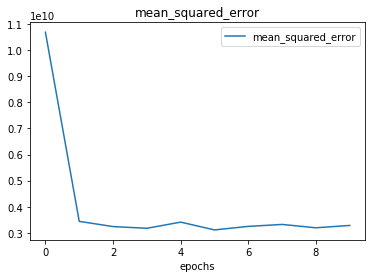

In [34]:
epochs = num_epochs
x = range(epochs)
plt.plot(x, stack.history['mean_squared_error'], label="mean_squared_error")
plt.xlabel('epochs')
plt.title("mean_squared_error")
plt.legend()
plt.show()

## テストデータ(X_val)に対してのAccuray

In [35]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 3854453016.547945
Test accuracy: 3854453200.0


# 【問題5】MNISTをKerasで学習
Sprint14で作成したMNISTデータセットによる画像の多値分類をKerasに書き換えてください。

### データ読み込み

In [36]:
# X_train, y_train→学習・検証用　
# X_val, y_val→テスト用
(X_train, y_train), (X_val, y_val) = mnist.load_data()

In [37]:
X_train = X_train.reshape(-1, 784)
X_val = X_val.reshape(-1, 784)

In [38]:
X_train = X_train.astype(np.float)
X_val = X_val.astype(np.float)
X_train /= 255
X_val /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

1.0
0.0


### OneHotEncoding

In [39]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_val_one_hot = enc.transform(y_val[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

(60000,)
(60000, 10)
float64


In [40]:
# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train_one_hot, test_size=0.2, random_state=0)

In [55]:
X_train.shape

(48000, 784)

### 学習・予測

In [56]:
# ハイパーパラメータの設定
learning_rate = 0.001
batch_size = 10
num_epochs = 10
verbose = 1
output_n_ch = 10

n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
# n_classes = 10

# # 計算グラフに渡す引数の形を決める
# X = tf.placeholder("float", [None, n_input])
# Y = tf.placeholder("float", [None, n_classes])

"""
単純な3層ニューラルネットワーク
"""
# モデルをコンパイル
model = tf.keras.Sequential([
            tf.keras.layers.Dense(n_hidden1, activation = tf.nn.relu, input_shape=(n_input,)),
            tf.keras.layers.Dense(n_hidden2, activation = tf.nn.relu),
            tf.keras.layers.Dense(output_n_ch, activation = tf.nn.softmax)])


model.compile(loss='categorical_crossentropy', optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate), metrics=['categorical_accuracy'])

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    verbose=verbose,
                    validation_data=(X_test, y_test))

print('\nテストデータに対しての予測')
# y_pred_proba = model.predict(X_test)[:,0]
y_pred_proba = model.predict(X_val)

# Softmaxの出力データの中で、最も高い値のindexを取得
y_pred = np.argmax(y_pred_proba, axis=1)

print('y_pred_proba', y_pred_proba)
print('y_pred\n', y_pred)


Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 5s 107us/sample - loss: 0.2578 - categorical_accuracy: 0.9226 - val_loss: 0.1444 - val_categorical_accuracy: 0.9568
Epoch 2/10
48000/48000 [==============================] - 5s 103us/sample - loss: 0.1244 - categorical_accuracy: 0.9623 - val_loss: 0.1101 - val_categorical_accuracy: 0.9671
Epoch 3/10
48000/48000 [==============================] - 5s 103us/sample - loss: 0.0915 - categorical_accuracy: 0.9724 - val_loss: 0.1224 - val_categorical_accuracy: 0.9637
Epoch 4/10
48000/48000 [==============================] - 5s 102us/sample - loss: 0.0728 - categorical_accuracy: 0.9769 - val_loss: 0.1010 - val_categorical_accuracy: 0.9714
Epoch 5/10
48000/48000 [==============================] - 5s 105us/sample - loss: 0.0603 - categorical_accuracy: 0.9809 - val_loss: 0.0971 - val_categorical_accuracy: 0.9723
Epoch 6/10
48000/48000 [==============================] - 5s 104us/sample - loss

In [47]:
target_names = []
for i in range(10):
    target_names.append('class' + str(i))

target_names

['class0',
 'class1',
 'class2',
 'class3',
 'class4',
 'class5',
 'class6',
 'class7',
 'class8',
 'class9']

## 評価値(対テストデータ)
### Accuracy

In [59]:
accuracy_score(y_val, y_pred)

0.9744

### Precision、recall、f1

In [57]:
print(classification_report(y_val, y_pred, target_names=target_names))

              precision    recall  f1-score   support

      class0       0.98      0.99      0.99       980
      class1       0.99      0.99      0.99      1135
      class2       0.97      0.98      0.98      1032
      class3       0.98      0.97      0.97      1010
      class4       0.97      0.98      0.97       982
      class5       0.97      0.96      0.97       892
      class6       0.99      0.96      0.97       958
      class7       0.97      0.97      0.97      1028
      class8       0.98      0.97      0.97       974
      class9       0.94      0.98      0.96      1009

   micro avg       0.97      0.97      0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

